Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\rouat\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:05:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleurs paramètres :
{'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1}
Modèle sauvegardé dans : C:\Users\rouat\Desktop\final\features_fusion\xgb_fusion_model.pkl

Classification Report :

              precision    recall  f1-score   support

         1.0       0.47      0.10      0.17       196
         2.0       0.91      0.90      0.91      3727
         3.0       0.47      0.22      0.30       561
         4.0       0.59      0.80      0.68      1040
         5.0       0.68      0.79      0.73       191
         6.0       0.71      0.47      0.56       117
         7.0       0.98      1.00      0.99      5746

    accuracy                           0.89     11578
   macro avg       0.68      0.61      0.62     11578
weighted avg       0.88      0.89      0.88     11578



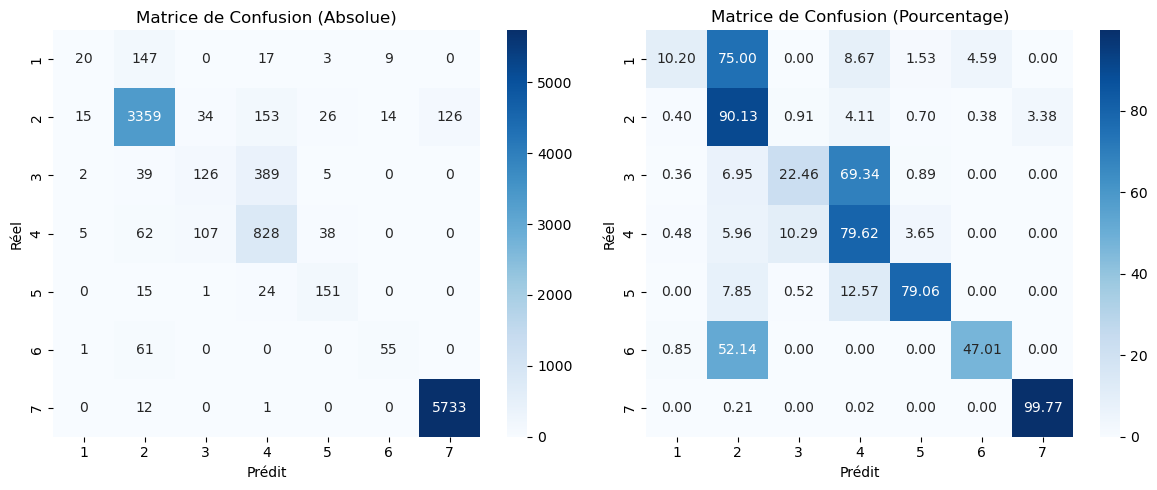

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib  

# Charger les fichiers fusionnés
train_file = r"C:\Users\rouat\Desktop\final\features_fusion\train_fusion.csv"
val_file   = r"C:\Users\rouat\Desktop\final\features_fusion\val_fusion.csv"
test_file  = r"C:\Users\rouat\Desktop\final\features_fusion\test_fusion.csv"

train_df = pd.read_csv(train_file)
val_df   = pd.read_csv(val_file)
test_df  = pd.read_csv(test_file)

# Séparer features et labels
ignore_cols = ['timestamp', 'object_id', 'behavior']
X_train = train_df.drop(columns=ignore_cols)
y_train = train_df['behavior']

X_val = val_df.drop(columns=ignore_cols)
y_val = val_df['behavior']

X_test = test_df.drop(columns=ignore_cols)
y_test = test_df['behavior']

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# Définir le modèle
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# hyperparamètres
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,            
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Entraînement
search.fit(X_train, y_train_enc)

print("Meilleurs paramètres :")
print(search.best_params_)

# Sauvegarder le modèle entraîné
model_save_path = r"C:\Users\rouat\Desktop\final\features_fusion\xgb_fusion_model.pkl"
joblib.dump(search.best_estimator_, model_save_path)
print(f"Modèle sauvegardé dans : {model_save_path}")


# Évaluation

y_pred = search.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)

print("\nClassification Report :\n")
print(classification_report(y_test, y_pred_labels))

# Matrice de confusion



y_test_corrected = y_test_enc + 1
y_pred_corrected = y_pred + 1

cm = confusion_matrix(y_test_corrected, y_pred_corrected, labels=np.arange(1,8))
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1,8), yticklabels=np.arange(1,8))
plt.title("Matrice de Confusion (Absolue)")
plt.xlabel("Prédit")
plt.ylabel("Réel")

plt.subplot(1,2,2)
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.arange(1,8), yticklabels=np.arange(1,8))
plt.title("Matrice de Confusion (Pourcentage)")
plt.xlabel("Prédit")
plt.ylabel("Réel")

plt.tight_layout()
plt.show()
